In [1]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload

# Show plots in the notebook
%matplotlib inline

#%matplotlib notebook

#### Import Libraries

In [2]:
import sys
import numpy as np
from scipy import optimize
from scipy.stats import norm
from scipy.stats import halfnorm
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import datetime
import time
import csv

In [3]:
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

#### Plot Formatting Defaults

In [4]:
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['font.family'] = 'serif'

#### Directory defaults

In [5]:
# Ten minutes with a Cs-137 source
#data_dir = r".\2018-05-03"
#data_file = "%s\counts_cesium_ten_minutes.txt" % (data_dir)

# Data from the tethered launch
#data_dir = r".\2018-05-08"
#data_file = "%s\counts_tethered_launch.txt" % (data_dir)

# Data from the launch!
data_dir = r".\2018-05-13"
counts_file = "%s/counts_launch.txt" % (data_dir)
star_file = "%s/counts_launch.csv" % (data_dir)
tel_file = "%s/telemetrydata.txt" % (data_dir)
gps_file = "%s/pits_gps.txt" % (data_dir)
pits_file = "%s/pits_images.txt" % (data_dir)
msi_file = "%s/msi_images.txt" % (data_dir)

msi_seeds = np.array([int(391900854), int(18925409), int(315370512)])

joined_file = "%s/data_joined.csv" % (data_dir)

pat = "^\$\$KC1FNU,\d*,(\d+)\:(\d+)\:(\d+),([0-9.]*),-([0-9.]*),(\d*),[0-9,.-]*\*([0-9A-F]*)$"
pat1 = "^\$GNGGA,(\d{2})(\d{2})(\d{2}).\d{2},(\d{2})([0-9.]{1,}),N,(\d{3})([0-9.]{1,}),W,\d{1,},\d{1,},[0-9.]{1,},([0-9.]{1,}),M,[0-9.-]{1,},M,.*?$"
pat2 = "^.*?\s{1,}((\d{2})_(\d{2})_(\d{2})-rot.jpg)\s*$"
pat3 = "^.*?\s{1,}(\d{4}-\d{2}-\d{2}_(\d{2})(\d{2})(\d{2})-(\d{1,})-cam(\d{1}).jpg)\s*$"

#### Definitions

In [6]:
# See if a value is a number or not
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Convert a number to float or int
def cvt_number(s):
    if ('.' in s):
        num = float(s)
    else:
        num = int(s)
    return num

# Round a number to a certain number of decimal places
def round_precision(num, precision):
    p10 = 10**precision
    num = num * p10
    num = np.ceil(num)
    num = num / p10
    return num

# Calculate a running mean/moving average
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Calculate the average deadtime per interval
def avg_deadtime(dead_time, deadt_counts):
    # Divide in such a way that division by zero doesn't halt the program
    # Instead, it returns a zero
    avg_deadt = np.divide(dead_time, deadt_counts, out=np.zeros_like(dead_time), where=deadt_counts!=0)
    return avg_deadt

# When HV isn't on, the counts are -1, so trim those entries
def enforce_min_counts(seconds, counts, dead_time, deadt_counts, T_raw, T, P_raw, P1, P2, alt, min_counts):
    seconds = np.array(seconds[np.where(deadt_counts >= min_counts)])
    counts = np.array(counts[np.where(deadt_counts >= min_counts)])
    T_raw = np.array(T_raw[np.where(deadt_counts >= min_counts)])
    T = np.array(T[np.where(deadt_counts >= min_counts)])
    P_raw = np.array(P_raw[np.where(deadt_counts >= min_counts)])
    P1 = np.array(P1[np.where(deadt_counts >= min_counts)], dtype='float64')
    P2 = np.array(P2[np.where(deadt_counts >= min_counts)], dtype='float64')
    alt = np.array(alt[np.where(deadt_counts >= min_counts)])
    dead_time = np.array(dead_time[np.where(deadt_counts >= min_counts)])
    deadt_counts = np.array(deadt_counts[np.where(deadt_counts >= min_counts)])
    seconds_dt = np.gradient(seconds)
    
    return seconds, seconds_dt, counts, dead_time, deadt_counts, T_raw, T, P_raw, P1, P2, alt

# Find all indices that have a minimum number of counts
def loc_min_counts(counts, min_counts):
    return np.where(counts >= min_counts)

# Corrects counts for dead time, avg_deadt can be a scalar or a per-interval array
def deadt_correction(seconds_dt, deadt_counts, avg_deadt):
    counts_c = deadt_counts / (1 - (deadt_counts/seconds_dt) * avg_deadt)
    return counts_c

def altitude_logarithmic(P, T, QFF):
    # ftp://ftp.nist.gov/pub/physics/lunarproject/References/Atmospheric_Properties/Pressure%20to%20Altitude%20Conversion%20%232.pdf
    P_0 = np.array(np.ones_like(P) * QFF, dtype='float64')
    T_0 = 288.150
    alt = (10**(np.log10(P/P_0)/5.2558797)- 1)/(-6.8755856*10**(-6))
    alt = alt * (T[0]+273.15)/T_0
    alt = alt * 0.3048  # Convert to meters
    return alt

def altitude_hypsometric(T, P):
    N = 2
    R = 287.058
    g = 9.80665
    
    dz = np.zeros_like(T)
    
    for i in range(1, len(T)):
        T_ave = ((T[i] + T[i-1]) / 2.0) + 273.15
        P1 = P[i-1]
        P2 = P[i]
        
        dz[i] = (R * T_ave / g) * np.log(P1/P2)
    
    alt = np.cumsum(dz)
    
    return alt

#### Read the data file

In [7]:
# STAR log file began at 12:59:55 EST on 5-13-2018

try:
    if os.path.isfile(star_file):
        df_star = pd.read_csv(star_file, index_col='Elapsed')
        
except:
    # The CSV file has a header row
    header = True

    # Read the CSV file into a Pandas DataFrame
    with open(counts_file, 'rb') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in csvreader:
            if (header):
                indexName  = row[0]   # assume that first column label is the index
                df_columns = row[1:]  # second through final header become DataFrame column names
                df_star = pd.DataFrame(columns=df_columns)
                header = False
                next
            else:
                for ii in range(len(row)):
                    if is_number(row[ii]):
                        row[ii] = cvt_number(row[ii])
                    df_star = df_star.append(pd.DataFrame([row[1:]], columns=df_columns, index=[row[0]]), ignore_index=False)

    df_star.to_csv(star_file, sep=',')

In [8]:
# Telemetry log file began at 13:40:03 EST on 5-13-2018 (17:40:03Z)
# This is 0:40:08 after STAR began logging

try:
    if os.path.isfile(tel_file):
        with open(tel_file, 'r') as telfile:
            indexName = ['Elapsed']
            df_columns = ['Timestamp', 'Lat', 'Long', 'Elev']
            df_tel = pd.DataFrame(columns=df_columns)
            for row in telfile:
                try:
                    m = re.match(pat, row)
                    if (m):
                        dt = datetime.datetime(2018, 5, 13, (int(m.group(1))-4), int(m.group(2)), int(m.group(3)))
                        hh = int(m.group(1)) - 17  # Telemetry was in Zulu time
                        mm = int(m.group(2)) - 40 + 40  # To sync with STAR data
                        ss = int(m.group(3)) - 3 + 8    # To sync with STAR data
                        elapsed_time = hh * 3600 + mm * 60 + ss
                        df_tel = df_tel.append(pd.DataFrame([[dt, float(m.group(4)), -1*float(m.group(5)), float(m.group(6))]], columns=df_columns, index=[elapsed_time]), ignore_index=False)
                    else:
                        print row
                except:
                    print "Exception."
    else:
        print "File not found!"
except:
    print "File IO error."

# Remove any duplicates
df_tel = df_tel[~df_tel.index.duplicated(keep='first')]

In [9]:
# Valid GPS data begins at 13:40:03 EST on 5-13-2018 (17:40:03Z)
# This is 0:40:08 after STAR began logging

# Conversion from Degrees Minutes.m to Decimal Degrees
# https://www.directionsmag.com/site/latlong-converter/

try:
    if os.path.isfile(gps_file):
        with open(gps_file, 'r') as gpsfile:
            indexName = ['Elapsed']
            df_columns = ['Datetime', 'Lat', 'Long', 'Elev']
            df_gps = pd.DataFrame(columns=df_columns)
            for row in gpsfile:
                
                # Try to match a regex
                try:
                    m = re.match(pat1, row)
                    
                    # Match
                    if (m):
                        
                        # Only include data from after 17Z and before 23Z
                        if ((int(m.group(1)) >= 17) and (int(m.group(1)) <= 23)):
                            #print m.group(1), m.group(2), m.group(3)
                            dt = datetime.datetime(2018, 5, 13, (int(m.group(1))-4), int(m.group(2)), int(m.group(3)))
                            hh = int(m.group(1)) - 17       # Telemetry was in Zulu time
                            mm = int(m.group(2)) - 40 + 40  # To sync with STAR data
                            ss = int(m.group(3)) - 3 + 8    # To sync with STAR data
                            elapsed_time = hh * 3600 + mm * 60 + ss
                            
                            lat = int(m.group(4)) + float(m.group(5)) / 60.0
                            lon = -1 * (int(m.group(6)) + float(m.group(7)) / 60.0)
                            elev = float(m.group(8))

                            df_gps = df_gps.append(pd.DataFrame([[dt, lat, lon, elev]], columns=df_columns, index=[elapsed_time]), ignore_index=False)
                    else:
                        next
                        #print row
                except:
                    print "Exception."
    else:
        print "File not found!"
except:
    print "File IO error."

In [10]:
# PITS images began at 13:40:31 EST on 5-13-2018
# This is 0:40:36 after STAR began logging

try:
    if os.path.isfile(pits_file):
        with open(pits_file, 'r') as pitsfile:
            indexName = ['Elapsed']
            df_columns = ['PITS Image']
            df_pits = pd.DataFrame(columns=df_columns)
            for row in pitsfile:
                
                # Try to match a regex
                try:
                    m = re.match(pat2, row)
                    
                    # Match
                    if (m):
                        hh = int(m.group(2)) - 13      # To sync with STAR data
                        mm = int(m.group(3)) - 40 + 40 # To sync with STAR data
                        ss = int(m.group(4)) - 31 + 36 # To sync with STAR data
                        elapsed_time = hh * 3600 + mm * 60 + ss
                        
                        df_pits = df_pits.append(pd.DataFrame([m.group(1)], columns=df_columns, index=[elapsed_time]), ignore_index=False)
                    else:
                        print row
                except:
                    next
    else:
        print "File not found!"
except:
    print "File IO error."





    Directory: C:\Users\c_nic\Documents\ASTR 202\pits





Mode                LastWriteTime         Length Name                                                                  

----                -------------         ------ ----                                                                  







In [11]:
# MSI images began at 13:39:34 EST on 5-13-2018
# This is 0:39:39 after STAR began logging

try:
    if os.path.isfile(msi_file):
        with open(msi_file, 'r') as msifile:
            indexName = ['Elapsed']
            df_columns = ['MSI Image', 'MSI IR Image']
            df_msi = pd.DataFrame(columns=df_columns)
            for row in msifile:
                try:
                    # Try to match a regex
                    m = re.match(pat3, row)
                    
                    # Match
                    if (m):
                        cam0 = m.group(1).replace("cam1", "cam0")
                        cam1 = m.group(1).replace("cam0", "cam1")
                        
                        # There are three randomly generated "seeds" appended to the filenames
                        # Each "seed" corresponds to a reboot
                        seed = int(m.group(5))
                        
                        try:
                            which_seed = int(np.where(msi_seeds == seed)[0][0])

                            # Normal operation
                            if (which_seed == 0):
                                # MSI images began at 13:39:34
                                #print m.group(2), m.group(3), m.group(4)
                                hh = int(m.group(2)) - 13
                                mm = int(m.group(3)) - 39 + 39  # To sync with STAR data
                                ss = int(m.group(4)) - 34 + 39  # To sync with STAR data
                                elapsed_time = hh * 3600 + mm * 60 + ss
                                
                                df_msi = df_msi.append(pd.DataFrame([[cam0, cam1]], columns=df_columns, index=[elapsed_time]), ignore_index=False)
                            
                            # First reboot
                            elif (which_seed == 1):
                                # Reboot happened around 15:07:35 and lasted 4.5s
                                # This was determined using syslog and the last image timstamp
                                # Time was reset to 12:00:00
                                # This is 1:28:01 after MSI began logging

                                #print m.group(2), m.group(3), m.group(4)
                                hh = int(m.group(2)) - 12 + 0  + 1
                                mm = int(m.group(3)) - 0  + 39 + 28     # To sync with STAR data
                                ss = int(m.group(4)) - 0  + 39 + 1 + 5  # To sync with STAR data
                                elapsed_time = hh * 3600 + mm * 60 + ss

                                df_msi = df_msi.append(pd.DataFrame([[cam0, cam1]], columns=df_columns, index=[elapsed_time]), ignore_index=False)
                            
                            # Second reboot
                            elif (which_seed == 2):
                                # Reboot happened around 12:47:00 and lasted 3.3s
                                # This was determined using syslog and the last image timstamp
                                # Time was reset to 12:00:00
                                # This is 2:15:01 after MSI began logging
                                
                                #print m.group(2), m.group(3), m.group(4)

                                hh = int(m.group(2)) - 12 + 0  + 1  + 0
                                mm = int(m.group(3)) - 0  + 39 + 28 + 47
                                ss = int(m.group(4)) - 0  + 39 + 1  + 0  + 8
                                elapsed_time = hh * 3600 + mm * 60 + ss

                                df_msi = df_msi.append(pd.DataFrame([[cam0, cam1]], columns=df_columns, index=[elapsed_time]), ignore_index=False)
                            else:
                                print m.group(1)
                        except:
                            print "No seed found."
                    else:
                        print row
                except:
                    next
    else:
        print "File not found!"
except:
    print "File IO error."
    
# Sort the dataframe index to get the elapsed times in order
df_msi = df_msi.sort_index()

# Remove any duplicates
df_msi = df_msi[~df_msi.index.duplicated(keep='first')]





    Directory: C:\Users\c_nic\Documents\ASTR 202\msi





Mode                LastWriteTime         Length Name                                                                  

----                -------------         ------ ----                                                                  

No seed found.






In [12]:
print df_star.head(4)
print df_tel.head(4)
print df_gps.head(4)
print df_pits.head(4)
print df_msi.head(4)

             Counts   T (Raw)     T1 (C)   P (Raw)    P1 (mbar)    P2 (mbar)  \
Elapsed                                                                        
792305.504       -1   8424522  29.624726   6760918  1009.786643  1009.786643   
792306.504       -1   8424604  29.627446   6760768  1009.733632  1009.733632   
792307.504       -1   8424642  29.628707   6760756  1009.731755  1009.731755   
792308.504       -1   8424664  29.629437   6760868  1009.777593  1009.777593   

             Altitude (m)   Dead Time (s)   Dead Time Counts  
Elapsed                                                       
792305.504      97.012924             0.0                 -1  
792306.504      97.467407             0.0                 -1  
792307.504      97.483696             0.0                 -1  
792308.504      97.091202             0.0                 -1  
               Timestamp       Lat      Long   Elev
2408 2018-05-13 13:40:03  43.08361 -73.76945  105.0
2409 2018-05-13 13:40:04  43.08361 -7

In [13]:
# STAR data
seconds = df_star.index.values[1:]
counts = df_star.iloc[:,0].values[1:]
deadt = df_star.iloc[:,7].values[1:]
deadtc = df_star.iloc[:,8].values[1:]
T_raw = df_star.iloc[:,1].values[1:]
P_raw = df_star.iloc[:,3].values[1:]
T = df_star.iloc[:,2].values[1:]
P1 = df_star.iloc[:,4].values[1:]
P2 = df_star.iloc[:,5].values[1:]
alt = df_star.iloc[:,6].values[1:]

# Turn seconds into elapsed time from zero
elapsed = seconds - seconds[0]

# GPS data
tel_seconds = df_gps.index.values[:]
tel_dt = pd.to_datetime(np.array(df_gps.iloc[:,0].values[:]))
tel_ts = [time.mktime(i.timetuple()) for i in tel_dt]
tel_lat = np.array(df_gps.iloc[:,1].values[:], dtype='float')
tel_long = np.array(df_gps.iloc[:,2].values[:], dtype='float')
tel_alt = np.array(df_gps.iloc[:,3].values[:], dtype='float')

# PITS image data
pits_seconds = df_pits.index.values[:]
pits_fn = np.array(df_pits.iloc[:,0].values[:], dtype='str')

# MSI image data
msi_seconds = df_msi.index.values[:]
msi_fn = np.array(df_msi.iloc[:,0].values[:], dtype='str')
msi_ir = np.array(df_msi.iloc[:,1].values[:], dtype='str')

print tel_dt[0], tel_ts[0]
print elapsed[0], tel_seconds[0], pits_seconds[0], msi_seconds[0]

2018-05-13 13:40:03 1526233203.0
0.0 2408 2436 2379


In [14]:
# DO NOT USE

# Attempt to align the dataframes
# Telemetry: altitude max at 9927
# STAR: altitude max at 804614.504000
# STAR: log started at 12:59:55pm

#star_max = elapsed[np.where(P2==np.min(P2))][0]
#tel_max = tel_seconds[np.where(tel_alt==np.max(tel_alt))][0]

#print "STAR maximum altitude at: ", star_max
#print "Telemetry maximum altitude at: ", tel_max

# Align the two data sets
#tel_seconds2 = tel_seconds + (star_max - tel_max)  #+ 27
#pits_seconds2 = pits_seconds + (star_max - tel_max) + 27
#msi_seconds2 = msi_seconds + (star_max - tel_max) + 27

#print "Elapsed time offset: ", tel_seconds2[0], pits_seconds2[0], msi_seconds2[0]

In [15]:
# Create interpolation functions for the missing data
alt_func = interp1d(tel_seconds, tel_alt, fill_value='extrapolate')
lat_func = interp1d(tel_seconds, tel_lat, fill_value='extrapolate')
long_func = interp1d(tel_seconds, tel_long, fill_value='extrapolate')
ts_func = interp1d(tel_seconds, tel_ts, fill_value='extrapolate')

# Create an integer version of the seconds array
seconds2 = np.array(elapsed, dtype='int')

# Create arrays
lat2 = np.ones_like(seconds2) * np.nan
long2 = np.ones_like(seconds2) * np.nan
alt2 = np.ones_like(seconds2) * np.nan
dt2 = np.empty(len(seconds2), dtype='datetime64[s]')
fn2 = np.empty(len(seconds2), dtype='object')
msi_fn1 = np.empty(len(seconds2), dtype='object')
msi_fn2 = np.empty(len(seconds2), dtype='object')

# Create a binary value to indicate interpolated data
interp = np.zeros_like(seconds2)

# Set up timestamp extrapolation
ts_last = 0
ts_td = np.timedelta64(datetime.timedelta(seconds=1))

# Iterate all the seconds
for i in range(len(seconds2)):
    cur_sec = seconds2[i]
    
    # Try to locate data in the telemetry arrays
    try:
        tel_loc = np.where(tel_seconds == cur_sec)[0][0]
        alt2[i] = tel_alt[tel_loc]
        lat2[i] = tel_lat[tel_loc]
        long2[i] = tel_long[tel_loc]
        dt2[i] = np.datetime64(tel_dt[tel_loc])
        interp[i] = int(0)

    # Interpolate missing data
    except:
        
        # Only interpolate during the range of valid GPS data
        if ((cur_sec >= tel_seconds[0]) and (cur_sec <= tel_seconds[-1])):
            alt2[i] = alt_func(cur_sec)
            lat2[i] = lat_func(cur_sec)
            long2[i] = long_func(cur_sec)
            interp[i] = int(1)
            
        # Otherwise, set everything to NaN
        else:
            alt2[i] = np.nan
            lat2[i] = np.nan
            long2[i] = np.nan
            interp[i] = int(0)

        # Try to get the last valid timestamp
        try:
            dt2[i] = np.datetime64(datetime.datetime.fromtimestamp(ts_func(cur_sec).tolist()))
            
        # Otherwise, extrapolate it by adding a second to last known timestamp
        except:
            dt2[i] = ts_last + ts_td

    # Is there a PITS image associated with this timestamp?
    try:
        pits_loc = np.where(pits_seconds == cur_sec)[0][0]
        fn2[i] = str(pits_fn[pits_loc])
        
    # No.
    except:
        fn2[i] = ''

    # Are there a MSI images associated with this timestamp?
    try:
        msi_loc = np.where(msi_seconds == cur_sec)[0][0]
        msi_fn1[i] = str(msi_fn[msi_loc])
        msi_fn2[i] = str(msi_ir[msi_loc])
        
    # No.
    except:
        msi_fn1[i] = ''
        msi_fn2[i] = ''

    # Capture the last timestamp
    ts_last = dt2[i]

In [16]:
# Create a new dataframe with all the data
df_columns = ['Datetime', 'Elapsed', 'Counts', 'T [Raw]', 'T1 [C]', 'P [Raw]', 'P1 [mbar]', 'P2 [mbar]', 'Altitude [m]', 'Dead Time [s]', 'Dead Time Counts', 'GPS Lat', 'GPS Long', 'GPS Elev [m]', 'Interp?', 'PITS Image', 'MSI Image', 'MSI IR Image']

# Zip all the data together
z = zip(dt2, seconds, counts, T_raw, T, P_raw, P1, P2, alt, deadt, deadtc, lat2, long2, alt2, interp, fn2, msi_fn1, msi_fn2)

# Populate the dataframe
df_final = pd.DataFrame(data=z, columns=df_columns, index=seconds2)

In [17]:
print df_final.head(4)

# Save the dataframe to file
df_final.to_csv(joined_file, sep=',', encoding='ascii')

assert(False)

             Datetime     Elapsed  Counts  T [Raw]     T1 [C]  P [Raw]  \
0 2018-05-13 12:59:55  792306.504      -1  8424604  29.627446  6760768   
1 2018-05-13 12:59:56  792307.504      -1  8424642  29.628707  6760756   
2 2018-05-13 12:59:57  792308.504      -1  8424664  29.629437  6760868   
3 2018-05-13 12:59:58  792309.504      -1  8424698  29.630565  6760812   

     P1 [mbar]    P2 [mbar]  Altitude [m]  Dead Time [s]  Dead Time Counts  \
0  1009.733632  1009.733632     97.467407            0.0                -1   
1  1009.731755  1009.731755     97.483696            0.0                -1   
2  1009.777593  1009.777593     97.091202            0.0                -1   
3  1009.758057  1009.758057     97.258713            0.0                -1   

   GPS Lat  GPS Long  GPS Elev [m]  Interp? PITS Image MSI Image MSI IR Image  
0      NaN       NaN           NaN        0                                    
1      NaN       NaN           NaN        0                                   

AssertionError: 

In [18]:
# Free up some RAM
del [[df_star, df_gps, df_pits, df_msi, df_tel]]

import gc
gc.collect()

df_star=pd.DataFrame()
df_gps=pd.DataFrame()
df_pits=pd.DataFrame()
df_msi=pd.DataFrame()
df_tel=pd.DataFrame()

assert(False)

AssertionError: 

### Get some data to use for plotting

In [19]:
seconds = np.array(df_final.index)
mins = seconds / 60.0
P2 = np.array(df_final['P2 [mbar]'])
T = np.array(df_final['T1 [C]'])

alt_star = np.array(df_final['Altitude [m]'])
alt_gps = np.array(df_final['GPS Elev [m]'])

dt = np.gradient(seconds)
dx = np.gradient(alt_gps)

elapsed = np.array(df_final['Elapsed'])
elapsed = elapsed - elapsed[0]

# Where are the counts >= 0?
counts_min = loc_min_counts(df_final['Dead Time Counts'], 0)

# Time intervals
star_dt = np.gradient(elapsed)

# Average dead time
avg_deadt = avg_deadtime(df_final['Dead Time [s]'], df_final['Dead Time Counts'])

# Dead time correction
counts_c = deadt_correction(star_dt, df_final['Dead Time Counts'], avg_deadt)

# Counts and Pressure vs Time (Wes)

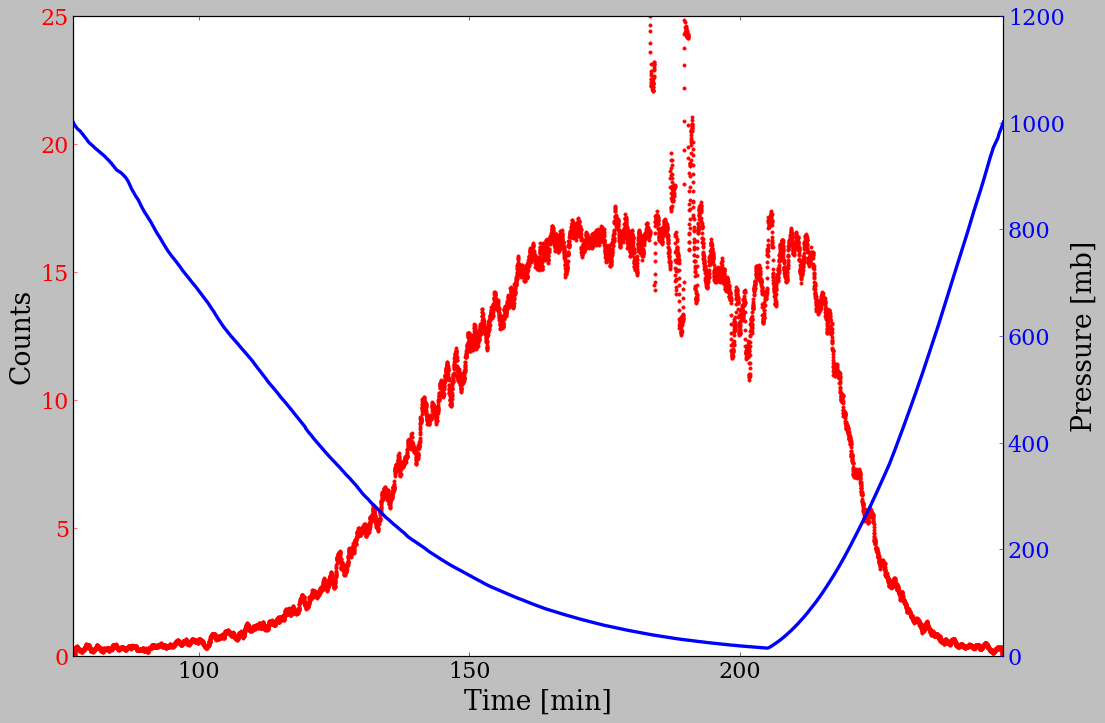

In [21]:
counts_smoothed = savgol_filter(counts_c, 51, 1)

fig, ax1 = plt.subplots()

ax1.plot(mins[counts_min], counts_smoothed[counts_min], 'r.')
ax1.tick_params('y', colors='r')
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Counts")
ax1.set_ylim([0, 25])

ax2 = ax1.twinx()
ax2.plot(mins[counts_min], P2[counts_min], 'b-', linewidth=3)
ax2.tick_params('y', colors='b')
ax2.set_ylabel("Pressure [mb]")

plt.xlim([mins[counts_min][0], mins[counts_min][-1]])

plt.savefig("%s/counts_pressure_time.png" % (data_dir), dpi=300)
plt.show()

# Counts vs Pressure (Wes)

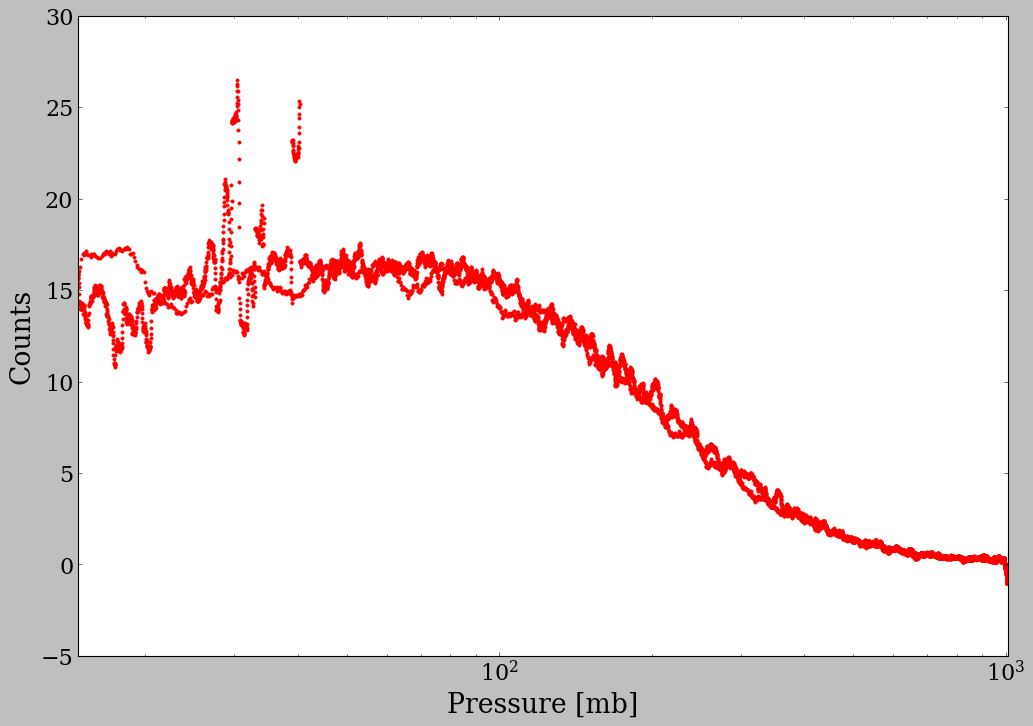

In [23]:
plt.close()

plt.semilogx(P2, counts_smoothed, 'r.')
plt.xlabel("Pressure [mb]")
plt.ylabel("Counts")

plt.xlim([np.min(P2), np.max(P2)])

plt.savefig("%s/counts_pressure.png" % (data_dir), dpi=300)
plt.show()

# Elevation vs Time (Wes)

25789.4074324 nan


C:\Python27\lib\site-packages\matplotlib\transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


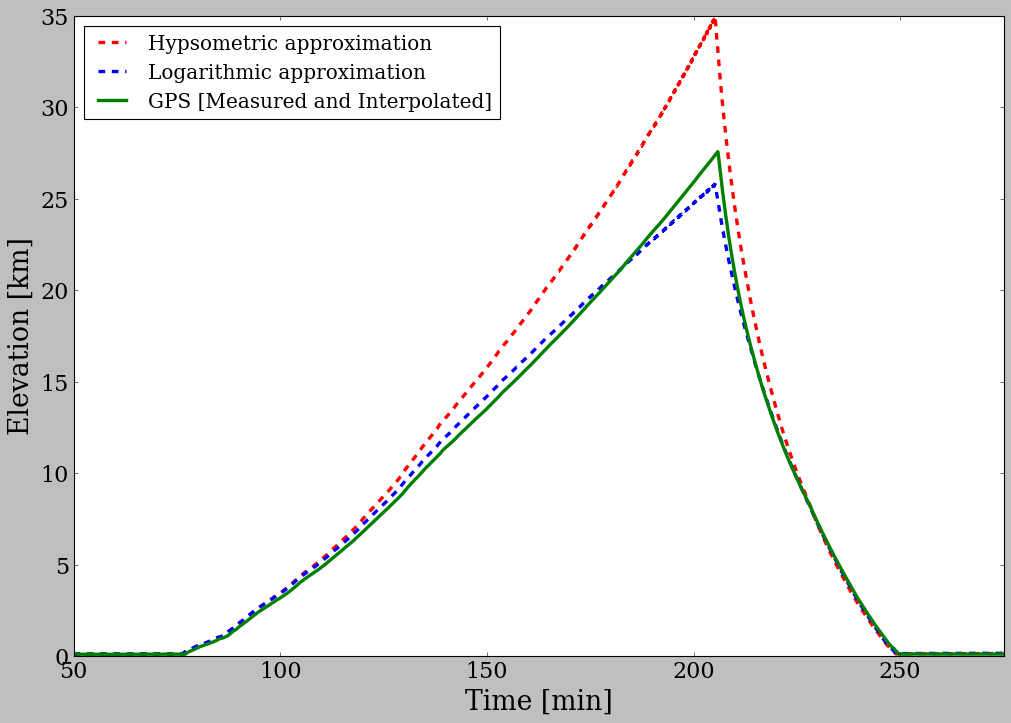

In [25]:
plt.close()

QFF = 1022  # https://weather.us/observations/new-york/pressure-qff/20180513-1500z.html
alt_log = altitude_logarithmic(P2, T, QFF)
#alt_h = altitude_hypsometric(T, P2)

print np.max(alt_log), np.max(alt_gps)

plt.plot(mins, alt_star/1000.0, 'r--', linewidth=3, label="Hypsometric approximation")
plt.plot(mins, alt_log/1000.0, 'b--', linewidth=3, label="Logarithmic approximation")
plt.plot(mins, alt_gps/1000.0, 'g-', linewidth=3, label="GPS [Measured and Interpolated]")
plt.xlabel("Time [min]")
plt.ylabel("Elevation [km]")
plt.legend(loc='best')

plt.xlim([50, 275])

plt.savefig("%s/elevation_time.png" % (data_dir), dpi=300)
plt.show()

# Counts and Elevation vs Time

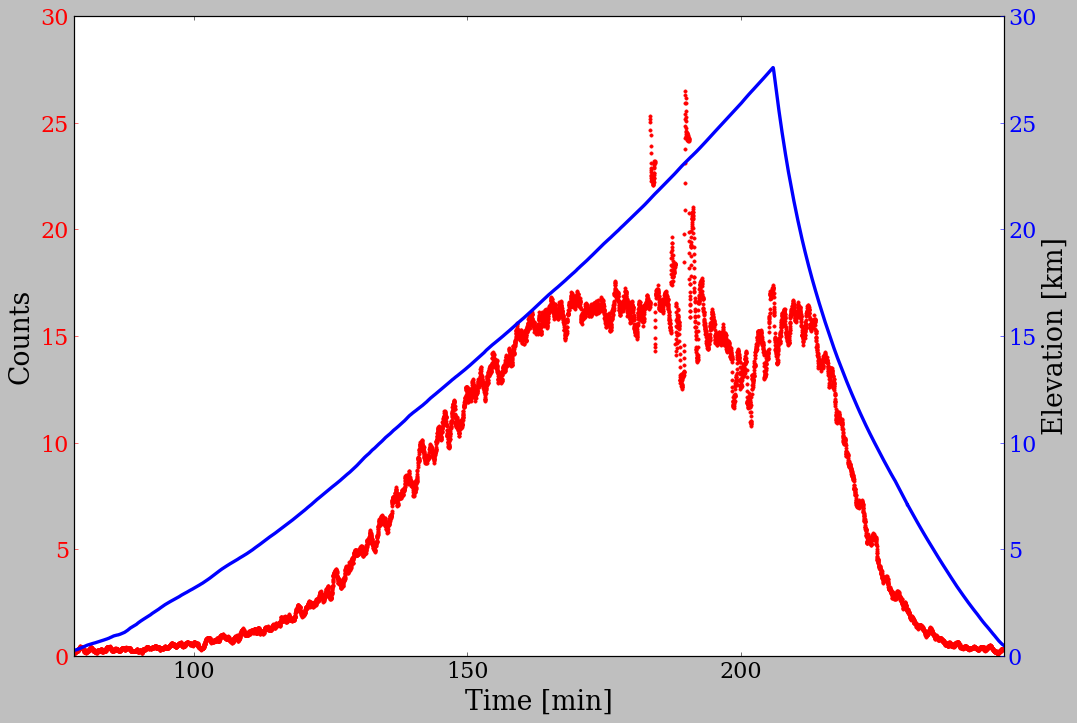

In [28]:
plt.close()

counts_smoothed = savgol_filter(counts_c, 51, 1)

fig, ax1 = plt.subplots()

ax1.plot(mins, counts_smoothed, 'r.', label="Counts")
ax1.tick_params('y', colors='r')
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()
ax2.plot(mins, alt_gps/1000.0, 'b-', linewidth=3)
ax2.tick_params('y', colors='b')
ax2.set_ylabel("Elevation [km]")

plt.xlim([78, 248])
ax1.set_ylim([0, 30])
ax2.set_ylim([0, 30])

plt.savefig("%s/counts_elevation_time.png" % (data_dir), dpi=300)
plt.show()

# Velocity (Wes)

C:\Python27\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Python27\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


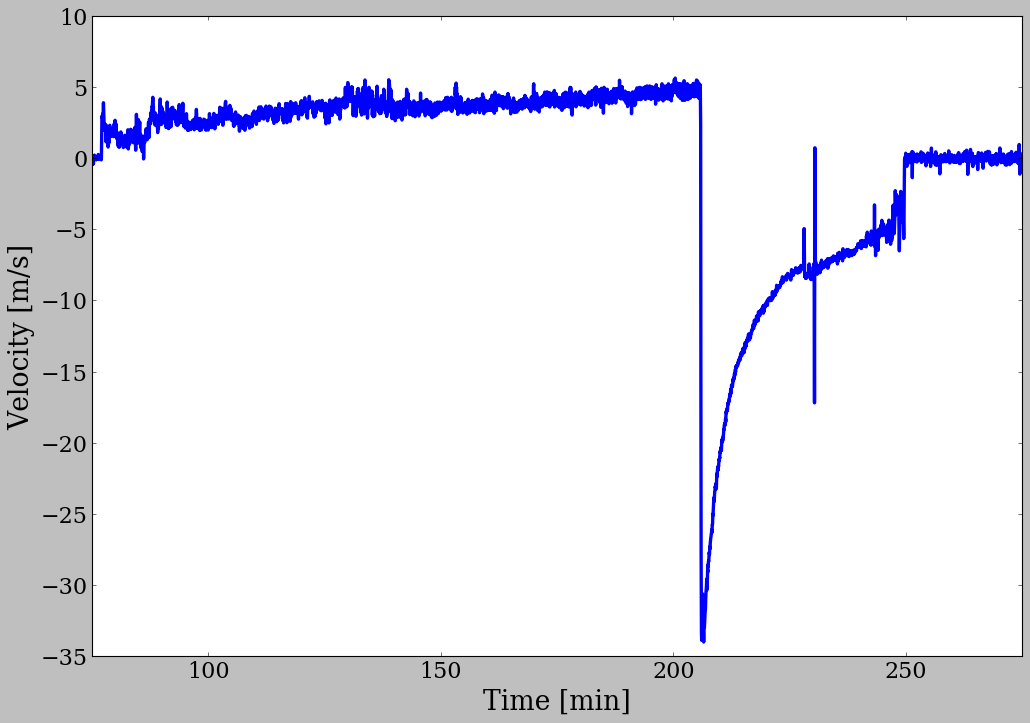

In [29]:
plt.close()

v = np.array(dx/dt, dtype='float64')
v_smooth = savgol_filter(v, 3, 1)

plt.ylabel("Velocity [m/s]")
plt.xlabel("Time [min]")

x = np.linspace(np.min(mins), np.max(mins), 1000)

plt.plot(mins, v_smooth, linewidth=3)
plt.xlim([75, 275])

plt.savefig("%s/velocity_time.png" % (data_dir), dpi=300)

plt.show()

# Velocity (Descent Only, Wes)

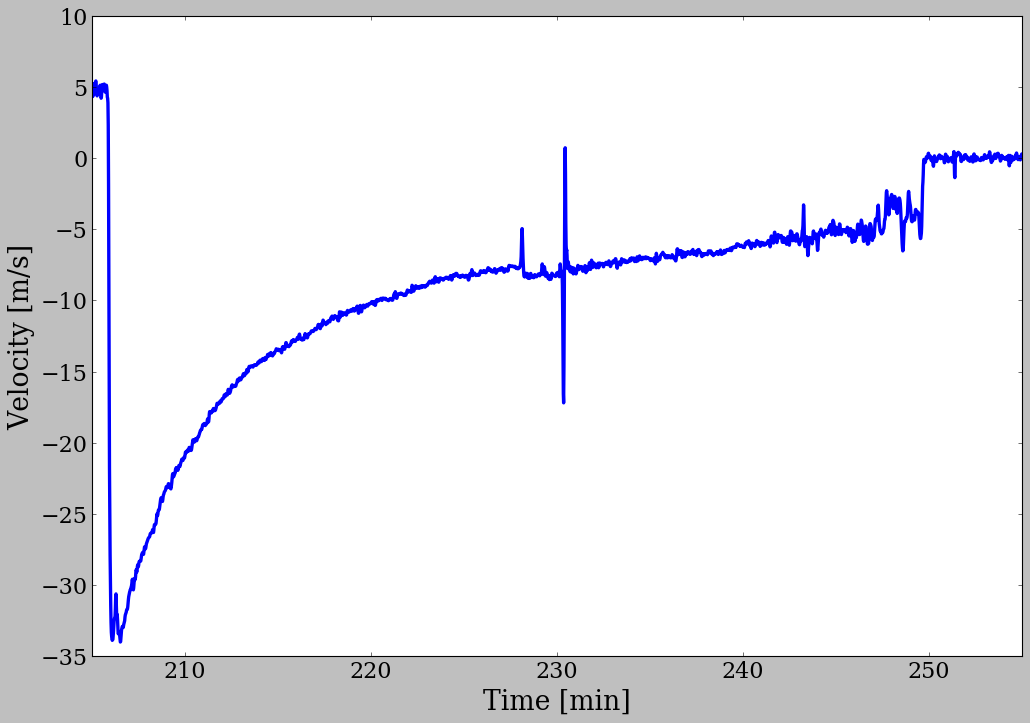

In [35]:
plt.close()

plt.ylabel("Velocity [m/s]")
plt.xlabel("Time [min]")

m = np.where(mins >= 205.0)

x = np.linspace(np.min(mins[m]), np.max(mins[m]), 1000)

plt.plot(mins[m], v_smooth[m], linewidth=3)
plt.xlim([205, 255])

plt.savefig("%s/velocity_descent.png" % (data_dir), dpi=300)

plt.show()

# Internal Temperature vs Time (Wes)

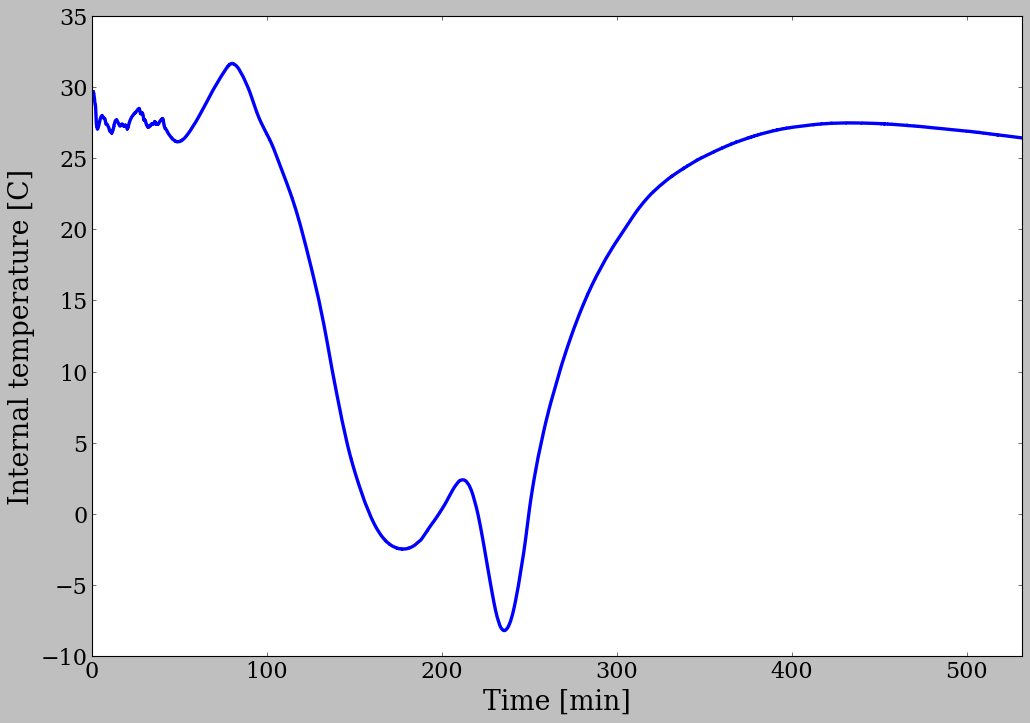

In [38]:
plt.ylabel("Internal temperature [C]")
plt.xlabel("Time [min]")

plt.plot(mins, T, linewidth=3)
plt.xlim([np.min(mins), np.max(mins)])

plt.savefig("%s/temperature_time.png" % (data_dir), dpi=300)

plt.show()

# Internal Temperature vs Elevation (Wes)

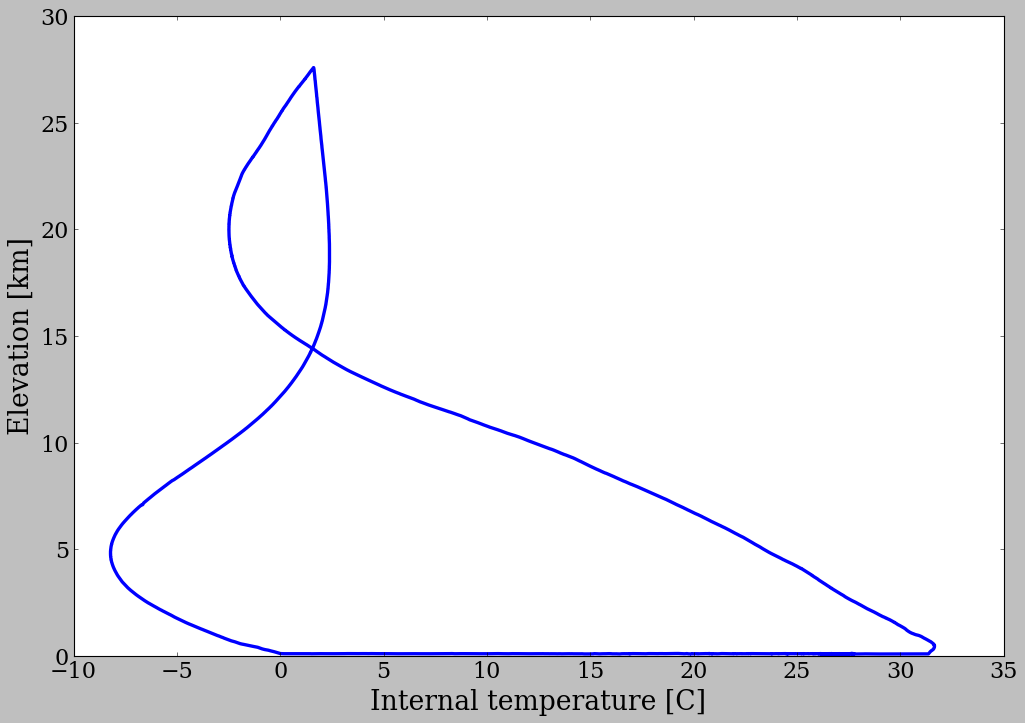

In [42]:
plt.xlabel("Internal temperature [C]")
plt.ylabel("Elevation [km]")

plt.plot(T, alt_gps/1000.0, linewidth=3)
plt.savefig("%s/elevation_temperature.png" % (data_dir), dpi=300)

plt.show()

# Time interval accuracy

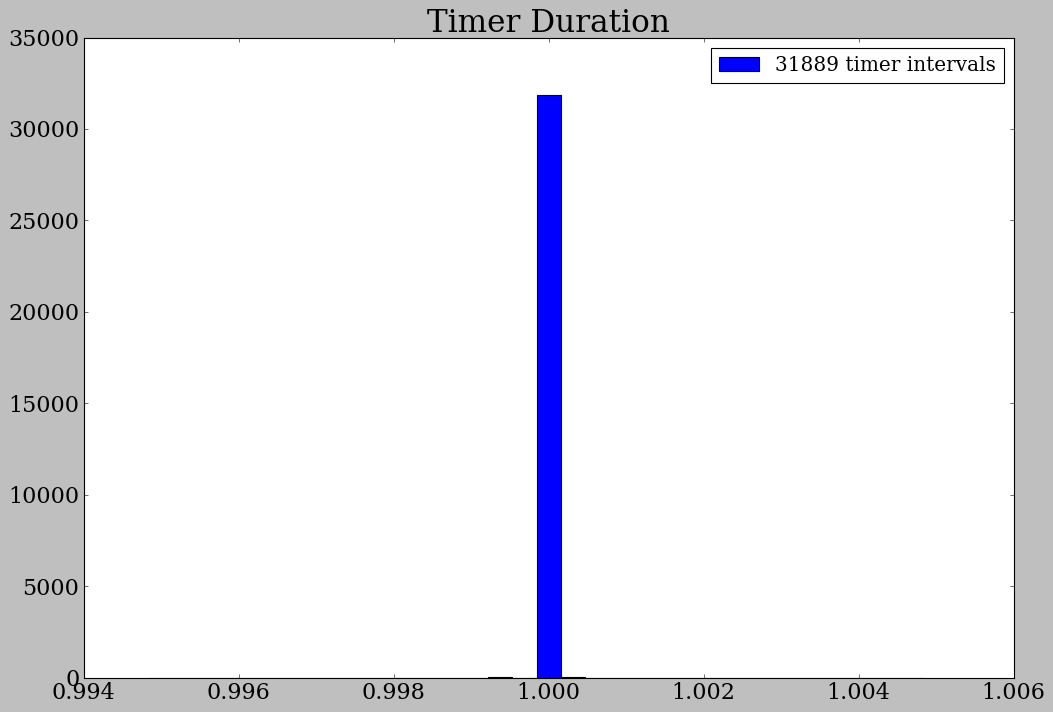

In [43]:
# How reliable is our counting loop?
mu, std = norm.fit(star_dt)

N = len(dt)

n, bins, patches = plt.hist(star_dt, bins=32, alpha=1.0, align='left', label="%d timer intervals" % N)

# Scale the normed distribution to fit our data
dx = bins[1] - bins[0]
scale = N*dx

# Plot the fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = scale*norm.pdf(x, mu, std)
#plt.plot(x, p, 'r--', linewidth=3, label="$\mu$=%.4f s,  $\sigma$=%.4f s" % (mu, std))

plt.title("Timer Duration")
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.legend(loc="best")
plt.show()

# Time interval outliers

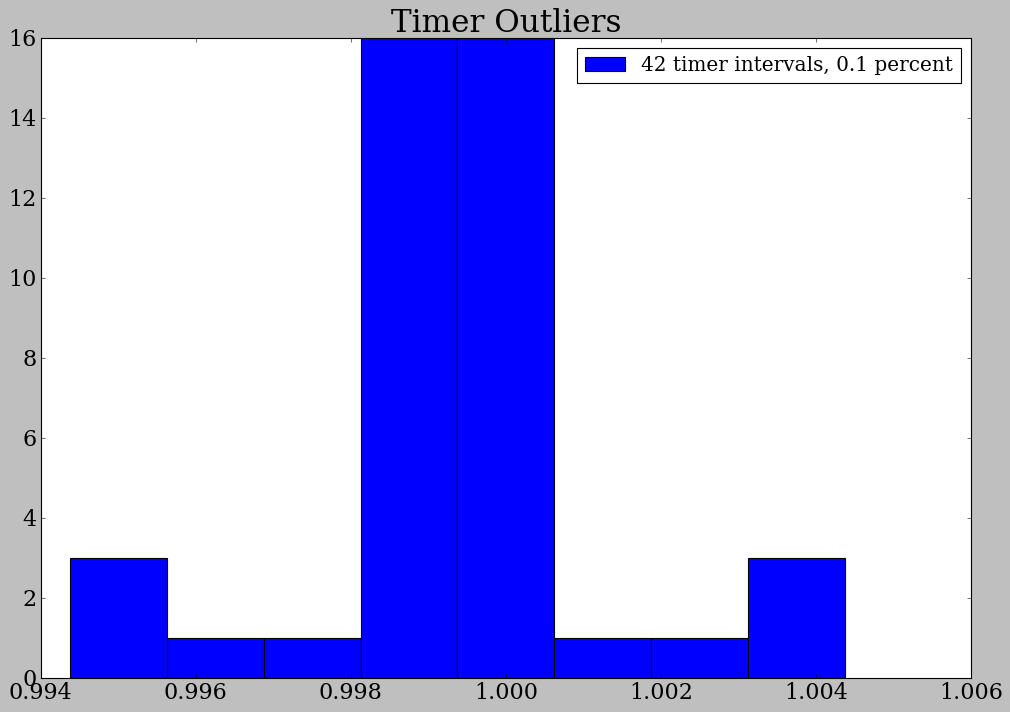

In [44]:
# Just look at the outliers
star_dt_o = star_dt[np.where(star_dt != 1.0)]

N_o = len(star_dt_o)
pct_o = (1.0 * N_o) / (1.0 * N) * 100.0

n, bins, patches = plt.hist(star_dt_o, bins=8, alpha=1.0, align='left', label="%d timer intervals, %0.1f percent" % (N_o, pct_o))

plt.title("Timer Outliers")
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.legend(loc="best")
plt.show()

# Histogram of counts/sec

In [ ]:
counts = df.iloc[:,0].values[1:]
seconds = df.index.values[1:]
seconds_dt = np.gradient(seconds)

cps = counts / seconds_dt
cps = np.array(cps[np.where(cps >= 0)], dtype='float64')

mincounts = 0

cps = cps[cps >= mincounts]
N = len(cps)

halfn = True

if (halfnorm):
    mu, std = halfnorm.fit(cps)
else:
    mu, std = norm.fit(cps)

n, bins, patches = plt.hist(cps, bins=8, alpha=1.0, align='mid', label="%d samples" % N)

# Scale the normed distribution to fit our data
dx = bins[1] - bins[0]

plt.xlim([min(cps), max(cps)])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)

if (halfnorm):
    scale = N * 2/(np.sqrt(np.pi)) * dx
    p = scale * halfnorm.pdf(x, mu, std)
else:
    scale = N*dx
    p = scale*norm.pdf(x, mu, std)
    
plt.plot(x, p, 'r--', linewidth=3, label="$\mu$=%.3f s$^{-1}$,  $\sigma$=%.3f s$^{-1}$" % (mu, std))

plt.xlabel("Counts per Second")
plt.title("Launch")
plt.legend(loc="best")
plt.show()

# Dead time correction of histogram

In [ ]:
seconds = df.index.values[1:]
counts = df.iloc[:,0].values[1:]
deadt = df.iloc[:,7].values[1:]
deadtc = df.iloc[:,8].values[1:]
T = df.iloc[:,2].values[1:]
P1 = df.iloc[:,4].values[1:]
P2 = df.iloc[:,5].values[1:]
alt = df.iloc[:,6].values[1:]

seconds, seconds_dt, counts, deadt, deadtc, T, P1, P2, alt = enforce_min_counts(seconds, counts, deadt, deadtc, T, P1, P2, alt, 0)

avg_deadt = avg_deadtime(deadt, deadtc)

counts_c = deadt_correction(seconds_dt, deadtc, avg_deadt)

bins = np.linspace(np.min(counts_c), np.max(counts_c), 32)
binwidth = bins[1]-bins[0]

plt.hist([counts, counts_c], bins, alpha=1.0, align='left', \
         label=["%d samples representing %.1f counts" % (len(counts), sum(counts)), \
                "%d corrected samples representing %.1f counts" % (len(counts_c), sum(counts_c))])

plt.xlim([np.min(counts_c)-binwidth, np.max(counts_c)+binwidth])

plt.xlabel("Counts per Second")
plt.title("Dead Time Correction, Launch")
plt.legend(loc="best")
plt.show()

# Average dead time

In [ ]:
if (len(avg_deadt) > 1):
    n, bins, patches = plt.hist(avg_deadt, bins=16, alpha=1.0, align='mid', \
         label="%d dead time samples" % len(avg_deadt))
    
    mu, std = norm.fit(avg_deadt)
    
    plt.xlim([min(avg_deadt), max(avg_deadt)])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)

    dx = bins[1] - bins[0]
    scale = N*dx
    p = scale*norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'r--', linewidth=3, label="$\mu$=%.6f s$^{-1}$,  $\sigma$=%.6f s$^{-1}$" % (mu, std))

    plt.xlabel("Dead Time Per Event (s)")
    plt.title("Average Dead Time Per Event")
    plt.legend(loc="best")
    plt.show()

# Pressure vs Temperature

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(T, P2, 'b-')
ax1.set_xlabel('Measured Temperature (C)')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Measured Pressure (mbar)', color='b')
ax1.tick_params('y', colors='b')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

ax2 = ax1.twinx()
ax2.plot(T, alt, 'r-')
ax2.set_ylabel('Calculated Altitude (m)', color='r')
ax2.tick_params('y', colors='r')

plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

plt.xlim(min(T), max(T))

#fig.tight_layout()
#plt.show()

ax = plt.axes(projection='3d')
ax.scatter(seconds-seconds[0], P2, T, c=seconds, cmap='viridis', linewidth=0.5)

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30
ax.zaxis.labelpad=30

ax.set_zlabel("Temperature [C]")
ax.set_ylabel('Pressure [mb]')
ax.set_xlabel('Elapsed Time [s]')

plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)


# 3D plot of time, altitude, counts

In [ ]:
seconds = df.index.values[1:]
counts = df.iloc[:,0].values[1:]
deadt = df.iloc[:,7].values[1:]
deadtc = df.iloc[:,8].values[1:]
T = df.iloc[:,2].values[1:]
P1 = df.iloc[:,4].values[1:]
P2 = df.iloc[:,5].values[1:]
alt = df.iloc[:,6].values[1:]

P1_min = np.min(P1)
P2_min = np.min(P2)
T_min = np.min(T)
alt_max = np.max(alt)

print P1_min, P2_min, T_min, alt_max

seconds, seconds_dt, counts, deadt, deadtc, T, P1, P2, alt = enforce_min_counts(seconds, counts, deadt, deadtc, T, P1, P2, alt, 0)

avg_deadt = avg_deadtime(deadt, deadtc)

counts_c = deadt_correction(seconds_dt, deadtc, avg_deadt)

ax = plt.axes(projection='3d')
ax.scatter(seconds-seconds[0], alt, counts_c, c=seconds, cmap='viridis', linewidth=0.5)

ax.set_zlabel("Corrected Counts")
ax.set_ylabel('Calculated Altitude (m)')
ax.set_xlabel('Elapsed Time (seconds)')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

plt.title("Altitude and Counts vs Elapsed Time")

plt.show()

# Corrected counts per second

In [ ]:
seconds = df.index.values[1:]
counts = df.iloc[:,0].values[1:]
deadt = df.iloc[:,7].values[1:]
deadtc = df.iloc[:,8].values[1:]
T = df.iloc[:,2].values[1:]
P1 = df.iloc[:,4].values[1:]
P2 = df.iloc[:,5].values[1:]
alt = df.iloc[:,6].values[1:]

seconds, seconds_dt, counts, deadt, deadtc, T, P1, P2, alt = enforce_min_counts(seconds, counts, deadt, deadtc, T, P1, P2, alt, 0)

avg_deadt = avg_deadtime(deadt, deadtc)

counts_c = deadt_correction(seconds_dt, deadtc, avg_deadt)

cps = counts_c/seconds_dt
cps_avg = np.sum(cps)/len(cps)

x = range(int(np.max(seconds)-seconds[0])+1)
y = np.ones_like(x)*cps_avg

plt.plot(x, cps, 'b-', linewidth='0.5', alpha=0.75, label="Counts")
plt.title("Corrected Counts per Second")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Corrected Counts")

#plt.plot(x, y, 'r-', linewidth="3", label="Average CPS: %.3f" % cps_avg)

plt.legend(loc='best')

plt.xlim(np.min(x), np.max(x))
plt.show()

# Pressure and corrected counts versus elapsed time

In [ ]:
seconds = df.index.values[1:]
counts = df.iloc[:,0].values[1:]
deadt = df.iloc[:,7].values[1:]
deadtc = df.iloc[:,8].values[1:]
T = df.iloc[:,2].values[1:]
P1 = df.iloc[:,4].values[1:]
P2 = df.iloc[:,5].values[1:]
alt = df.iloc[:,6].values[1:]

seconds, seconds_dt, counts, deadt, deadtc, T, P1, P2, alt = enforce_min_counts(seconds, counts, deadt, deadtc, T, P1, P2, alt, 0)

avg_deadt = avg_deadtime(deadt, deadtc)

counts_c = deadt_correction(seconds_dt, deadtc, avg_deadt)

# Let's smooth this a bit
counts_smoothed = counts_c
for i in range(0, 250):
    counts_smoothed = savgol_filter(counts_smoothed, 3, 1)

elapsed = seconds-seconds[0]
                                
#plt.plot(seconds, P2)
#plt.title("Pressure vs Elapsed Time")
#plt.xlabel("Elapsed Time (s)")
#plt.ylabel("Pressure (mbar)")
#plt.savefig("%s\pressure_time.png" % (data_dir), bbox_inches='tight')
#plt.show()

fig, ax1 = plt.subplots()
ax1.plot(elapsed, P2, 'b-')
ax1.set_xlabel('Elapsed Time (s)')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Pressure (mbar)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim([np.min(P2), np.max(P2)])

ax2 = ax1.twinx()
ax2.plot(elapsed, counts_smoothed, 'r-')
ax2.set_ylabel('Counts', color='r')
ax2.tick_params('y', colors='r')
ax2.set_ylim([np.min(counts_c), 25])

plt.title("Pressure and Counts vs Elapsed Time")
plt.xlim(np.min(elapsed), np.max(elapsed))
plt.savefig("%s\pressure_counts_time.png" % (data_dir), bbox_inches='tight')

fig.tight_layout()
plt.show()